I chose to take the frequency of occurrence of each word in the abstract into account. I thought this representation contains more information for the model to learn its decision boundary from. I converted the ‘class’ field to numeric values because I’d read that it might improve performance accuracy but this did not change anything. Originally I also chose to remove common, so-called “stop words” from the text before creating my models. This was done to get rid of commonly occurring words that might not contribute to class distinctions. These words might be increasing dimensionality and algorithmic cost without contributing much to boundary learning and predictive accuracy. 

I chose to use the set of English stop words available in the NLTK library. However this dramatically lowered the performance of all but the Transformed Complement Naive Bayes (TCNB) model. This is an indication that some of the eliminated words were of import to boundary learning. But I have no idea why TCNB was so resilient against this distributional shift. It is possible that the diminished performance of other models was caused by an increase in the difference of abstract length after this pre-processing step. This would make sense as the TCNB is designed to increase performance when document lengths vary. But more investigation is needed to confirm. 

The standard or Multinomial Naive Bayes (MNB) model already performed with over 90% accuracy on average, in stratified 100-fold cross validation. In addition to this model I chose to experiment with all but one (IDF transform) of the suggestions mentioned in ‘Tackling the Poor Assumptions of Naive Bayes Text Classifiers’. Only because the authors remarked that it was the least useful of the methods they tried. I also chose to experiment with different prior distributions.

The ‘weighted normalisation’ modification in the Weight-normalized Complement Naive Bayes (WCNB) was a huge disappointment, which only significantly reduced performance. The idea behind this modification was to relax the central independence assumption of the Naive Bayes algorithm. However it did not yield useful results. Complement Naive Bayes (CNB) proved to be the best model in my stratified 100-fold cross validation. Significantly out performing all other models. 

The high performance of CNB was not surprising as the modification is meant to aid in the analysis of highly skewed, unbalanced class distributions. It works by learning the decision boundary for any given class using the training data, not in that class. And our distribution is indeed highly skewed. Eukaryota: 53.6%, Bacteria: 40.05%, Archaea: 3.2%, Virus: 3.15%.

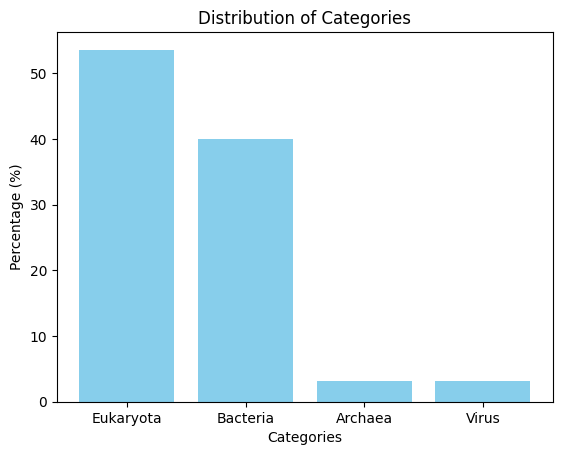

In [71]:
import matplotlib.pyplot as plt

categories = ['Eukaryota', 'Bacteria', 'Archaea', 'Virus']
percentages = [53.6, 40.05, 3.2, 3.15]

plt.bar(categories, percentages, color='skyblue')  
plt.xlabel('Categories')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Categories')

plt.show()


In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import pandas as pd
from scipy.stats import ttest_rel
from itertools import combinations

In [73]:
df_train = pd.read_csv('trg.csv')
print(df_train.head())

   id class                                           abstract
0   1     B  the 4 202 353 bp genome of the alkaliphilic ba...
1   2     A  the complete 1751377-bp sequence of the genome...
2   3     E  in 1992 we started assembling an ordered libra...
3   4     E  the aim of this study is to measure human mito...
4   5     B  the amino acid sequence of the spirulina maxim...


In [74]:
# Calculate the prior probabilities for each class
prior_probs = df_train['class'].value_counts(normalize=True).to_dict()

In [75]:
# If the current class is not already a key in the dictionary, 
# add it with an empty dictionary as its value
def add_class(dictionary, doc_class):
    if doc_class not in dictionary:
        dictionary[doc_class] = {}

# Increment the word's count in this dictionary by 1
def increment_count(dictionary, word):
    if word not in dictionary:
        dictionary[word] = 0
    dictionary[word] += 1


# Calculate the count of words in the abstracts, 
# grouped by class
def calculate_counts_by_class(df_train):
    word_counts = {}
    # Store the words and their counts, grouped by class
    for _ , document in df_train.iterrows():
        doc_class = document['class']
        add_class(word_counts, doc_class)
        abstract = document['abstract']
        for word in abstract.split():
            increment_count(word_counts[doc_class], word)
    return word_counts

In [76]:
# For each word in the abstract, alculate the number of times
# that word appears in the abstract
def calculate_fi(abstract):
    fi_counts = {}
    for word in abstract.split():
        increment_count(fi_counts, word)
    return fi_counts


# Total number of words for each class
def get_totals(counts_by_class):
    class_totals = {}
    for doc_class, words in counts_by_class.items():
        class_totals[doc_class] = sum(words.values())
    return class_totals


# Get the set of all unique words in the training data
def get_unique_words(counts_by_class):
    X = set()
    for words in counts_by_class.values():
        for word in words.keys():
             X.add(word)
    return X

In [77]:
# Calculate and store the probabilities for each word, gourped by class
# Regular, Multinomial Naive Bayes
def calculate_MNB_prob(counts_by_class, totals,vocab_size):
    word_probs = {}
    for doc_class in counts_by_class.keys():
        add_class(word_probs, doc_class)
        words = counts_by_class[doc_class]

        for word in words.keys():
             # Number of times word appears in this class
            Nci = words[word]
        
             # Number of words in the current class
            Nc = totals[doc_class]
            
            # Calculate the probabities using laplace smoothing
            word_probability = (Nci + 1) / (Nc + vocab_size)
        
            word_probs[doc_class][word] = word_probability
        
    return word_probs

In [78]:
def MNB_predict(test_df, MNB_probs, class_totals, vocab_size):
    predictions = []

    for _ , document in test_df.iterrows():
        max_boundary = -np.inf
        class_prediction = None
        
        abstract = document['abstract']
        fi_dict = calculate_fi(abstract)
        w = set()

        for doc_class , prior_prob in prior_probs.items():
            boundary = np.log(prior_prob)

            for word in abstract.split():
                if word in w:
                    continue

                if word in MNB_probs[doc_class].keys():
                    theta_i = (MNB_probs[doc_class][word])

                else:
                    # If the word isn't in the training set, use laplace smoothing
                    Nc = class_totals[doc_class]
                    theta_i = (1/ (Nc + vocab_size))

                boundary += fi_dict[word] * np.log(theta_i)
                w.add(word)
            
            if max_boundary < boundary:
                max_boundary = boundary
                class_prediction = doc_class
            
            w.clear()

        predictions.append(class_prediction)

    return predictions

In [79]:
# Complement Naive Bayes
def calculate_CNB_prob(counts_by_class, totals,vocab_size):
    word_probs = {}
    # Total number of words in the training set
    total_words = sum(totals.values())  

    for doc_class in counts_by_class.keys():
        add_class(word_probs, doc_class)
        words = counts_by_class[doc_class]

        # Total number of words in classes other than the current class
        Nc_comp = total_words - totals[doc_class]

        for word in words.keys():
            # Number of times the word appears in classes other than the current class
            Nci_comp = 0
            for other_class in counts_by_class.keys():
                if other_class != doc_class:

                    # If the word exists in the other class
                    if word in counts_by_class[other_class]:  
                        Nci_comp += counts_by_class[other_class][word]

            # Calculate the probabilities using laplace smoothing
            word_probability = (Nci_comp + 1) / (Nc_comp + vocab_size)

            word_probs[doc_class][word] = word_probability

    return word_probs


In [80]:
def calculate_theta_i(word, doc_class, CNB_probs, counts_by_class, class_totals, vocab_size, total_words):
    if word in CNB_probs[doc_class].keys():
        theta_i = (CNB_probs[doc_class][word])
    else:
        Nci_comp = 0
        for other_class in counts_by_class.keys():
            if other_class != doc_class:
                if word in counts_by_class[other_class]:  
                    Nci_comp += counts_by_class[other_class][word]
        Nc_comp = total_words - class_totals[doc_class]
        theta_i = ((Nci_comp + 1)/ (Nc_comp + vocab_size))
    return theta_i

In [81]:
def predict(test_df, CNB_probs, vocab_size, counts_by_class, class_totals, prior_probs, calculate_boundary):
    predictions = []
    boundaries = []

    total_words = sum(class_totals.values())

    for _ , document in test_df.iterrows():
        max_boundary = -np.inf
        class_prediction = None
        
        abstract = document['abstract']
        fi_dict = calculate_fi(abstract)
        w = set()

        for doc_class , prior_prob in prior_probs.items():
            boundary = np.log(prior_prob)
            Wci = {}

            for word in abstract.split():
                if word in w:
                    continue
                
                theta_i = calculate_theta_i(word, doc_class, CNB_probs, counts_by_class, class_totals, vocab_size, total_words)
                Wci[word] = np.log(theta_i)
                w.add(word)

            boundary = calculate_boundary(boundary, Wci, fi_dict)
            boundaries.append(boundary)

            if max_boundary < boundary:
                max_boundary = boundary
                class_prediction = doc_class
            
            w.clear()
            Wci.clear()

        predictions.append(class_prediction)

    return predictions, boundaries

In [82]:
def CNB_boundary(boundary, Wci, fi_dict):
    for word in Wci:
        boundary -= fi_dict[word] * Wci[word]
    return boundary

# Weight-normalized Complement Naive Bayes
def WCNB_boundary(boundary, Wci, fi_dict):
    sum_abs_log_theta_is = sum(abs(value) for value in Wci.values())
    for word in Wci:
        boundary -= np.log(1+fi_dict[word]) * (Wci[word]/sum_abs_log_theta_is)
    return boundary

# Transformed Complement Naive Bayes 
def TCNB_boundary(boundary, Wci, fi_dict):
    sum_sq_fi = sum(value**2 for value in fi_dict.values())
    sqrt_sum_sq_fi = sum_sq_fi**0.5
    for word in Wci:
        boundary -= (fi_dict[word]/sqrt_sum_sq_fi) * Wci[word]
    return boundary

In [83]:
def CNB_predict(test_df, CNB_probs, vocab_size, counts_by_class, class_totals, prior_probs):
    return predict(test_df, CNB_probs, vocab_size, counts_by_class, class_totals, prior_probs, CNB_boundary)

def WCNB_predict(test_df, CNB_probs, vocab_size, counts_by_class, class_totals, prior_probs):
    return predict(test_df, CNB_probs, vocab_size, counts_by_class, class_totals, prior_probs, WCNB_boundary)

def TCNB_predict(test_df, CNB_probs, vocab_size, counts_by_class, class_totals, prior_probs):
    return predict(test_df, CNB_probs, vocab_size, counts_by_class, class_totals, prior_probs, TCNB_boundary)

As previously mentioned I chose to conduct a stratified 100-fold cross validation procedure to select my model. The stratification was important because I wanted my validation and training folds to have similar distributions. I chose to perform 100-folds so that I could then confidently perform t-tests (adjusted for multiple comparisons using Bonferroni correction) without worrying about small sample sizes. I did not choose a higher number of folds as 100-folds was already enough to produce highly significant results and there was a limit (126) to the number of folds I could have while maintaining my evenly stratified folds. This is because there were only 126 articles of the ‘Virus’ class. 

In [84]:
# Stratified K-fold cross validation
k = 100
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=10)
split_ids = kfold.split(df_train['abstract'], df_train['class'])

# Fold number
i = 1

MNB_accuracies  = []
CNB_accuracies  = []
WCNB_accuracies = []
TCNB_accuracies = []

for train_ids, test_ids in split_ids:
    
    print(f"Fold {i}")
    
    df_train_fold = df_train.iloc[train_ids]
    df_test_fold = df_train.iloc[test_ids]

    counts_by_class = calculate_counts_by_class(df_train_fold)
    class_totals = get_totals(counts_by_class)

    # X is the set of all words
    X = get_unique_words(counts_by_class)
    # Get the size of X for laplace smoothing
    vocabulary_size = len(X)

    MNB_probabilities = calculate_MNB_prob(counts_by_class, class_totals, vocabulary_size)
    CNB_probabilities = calculate_CNB_prob(counts_by_class, class_totals, vocabulary_size)

    MNB_predictions = MNB_predict(df_test_fold,MNB_probabilities, class_totals, vocabulary_size)
    CNB_predictions , _ = CNB_predict(df_test_fold,CNB_probabilities, vocabulary_size,counts_by_class, class_totals, prior_probs)
    WCNB_predictions, _ = WCNB_predict(df_test_fold,CNB_probabilities, vocabulary_size,counts_by_class, class_totals, prior_probs)
    TCNB_predictions, _ = TCNB_predict(df_test_fold,CNB_probabilities, vocabulary_size,counts_by_class, class_totals, prior_probs)
    
    MNB_accuracy  = accuracy_score(df_test_fold['class'], MNB_predictions)
    CNB_accuracy  = accuracy_score(df_test_fold['class'], CNB_predictions)
    WCNB_accuracy = accuracy_score(df_test_fold['class'], WCNB_predictions)
    TCNB_accuracy = accuracy_score(df_test_fold['class'], TCNB_predictions)

    MNB_accuracies.append(MNB_accuracy)
    CNB_accuracies.append(CNB_accuracy)
    WCNB_accuracies.append(WCNB_accuracy)
    TCNB_accuracies.append(TCNB_accuracy)

    i += 1

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
Fold 11
Fold 12
Fold 13
Fold 14
Fold 15
Fold 16
Fold 17
Fold 18
Fold 19
Fold 20
Fold 21
Fold 22
Fold 23
Fold 24
Fold 25
Fold 26
Fold 27
Fold 28
Fold 29
Fold 30
Fold 31
Fold 32
Fold 33
Fold 34
Fold 35
Fold 36
Fold 37
Fold 38
Fold 39
Fold 40
Fold 41
Fold 42
Fold 43
Fold 44
Fold 45
Fold 46
Fold 47
Fold 48
Fold 49
Fold 50
Fold 51
Fold 52
Fold 53
Fold 54
Fold 55
Fold 56
Fold 57
Fold 58
Fold 59
Fold 60
Fold 61
Fold 62
Fold 63
Fold 64
Fold 65
Fold 66
Fold 67
Fold 68
Fold 69
Fold 70
Fold 71
Fold 72
Fold 73
Fold 74
Fold 75
Fold 76
Fold 77
Fold 78
Fold 79
Fold 80
Fold 81
Fold 82
Fold 83
Fold 84
Fold 85
Fold 86
Fold 87
Fold 88
Fold 89
Fold 90
Fold 91
Fold 92
Fold 93
Fold 94
Fold 95
Fold 96
Fold 97
Fold 98
Fold 99
Fold 100


In [85]:
# Convert results to DataFrame
df_results = pd.DataFrame(MNB_accuracies, columns=['MNB'])
df_results['CNB'] = CNB_accuracies
df_results['WCNB'] = WCNB_accuracies
df_results['TCNB'] = TCNB_accuracies

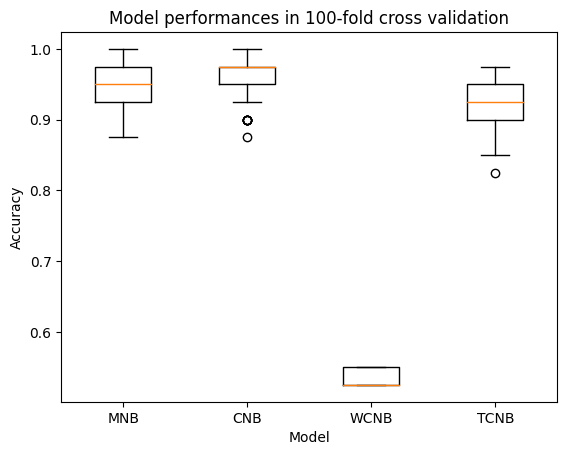

In [86]:
# Creating a boxplot for performance of each model

plt.boxplot([df_results[col] for col in df_results.columns])
plt.xticks(range(1, len(df_results.columns) + 1), df_results.columns)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Model performances in 100-fold cross validation')
plt.show()

In [87]:
# T-tests with Bonferroni correction
hypothesies_to_test = list(combinations(df_results.columns, 2))
alpha = 0.0001
adjusted_alpha = alpha / len(hypothesies_to_test)

for model_pairs in hypothesies_to_test:
    stat, p = ttest_rel(df_results[model_pairs[0]], df_results[model_pairs[1]])
    mean_diff = df_results[model_pairs[0]].mean() - df_results[model_pairs[1]].mean()
    if p < adjusted_alpha:
        print(f"Hightly significant difference between {model_pairs[0]} and {model_pairs[1]}: mean diff = {mean_diff}, p = {p}")


Hightly significant difference between MNB and CNB: mean diff = -0.015250000000000097, p = 1.2892676225087073e-12
Hightly significant difference between MNB and WCNB: mean diff = 0.4122499999999998, p = 1.953439571753716e-110
Hightly significant difference between MNB and TCNB: mean diff = 0.03149999999999964, p = 9.681556096152064e-19
Hightly significant difference between CNB and WCNB: mean diff = 0.4274999999999999, p = 1.6648604297776943e-113
Hightly significant difference between CNB and TCNB: mean diff = 0.046749999999999736, p = 1.9808675084506073e-29
Hightly significant difference between WCNB and TCNB: mean diff = -0.38075000000000014, p = 5.427776967821275e-109


In [88]:
# Save results as csv file
df_results.to_csv('results2.csv', index=False)

In [91]:
# The results show CNB is the best model
df_test = pd.read_csv('tst.csv')

# Predicting using Complement Naive Bayes
counts_by_class = calculate_counts_by_class(df_train)
class_totals = get_totals(counts_by_class)

# X is the set of all words
X = get_unique_words(counts_by_class)
# Get the size of X for laplace smoothing
vocabulary_size = len(X)

CNB_probabilities = calculate_CNB_prob(counts_by_class, class_totals, vocabulary_size)
CNB_predictions , _ = CNB_predict(df_test,CNB_probabilities, vocabulary_size,counts_by_class, class_totals, prior_probs)

predictions_df = pd.DataFrame()
predictions_df['id'] = df_test['id']
predictions_df['class'] = CNB_predictions

# Save to csv to upload to Kaggle
predictions_df.to_csv('predictions.csv', index=False)